In [118]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import eli5

from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from imblearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks
from xgboost import XGBClassifier
from xgboost import plot_importance
import xgboost as xgb

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import fbeta_score
from sklearn.metrics import make_scorer
from sklearn.metrics import roc_auc_score
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_curve


In [119]:
X = pd.read_csv('X.csv')
# X = pd.read_csv('s3://cxa-lc-data/X.csv')

y = pd.read_csv('y.csv')
# y = pd.read_csv('s3://cxa-lc-data/y.csv')

y = y.values.ravel()

In [120]:
#Creating just temporary small samples
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, stratify=y, random_state=42)

In [121]:
num_transform = Pipeline(steps=[
    ('imputer',SimpleImputer(strategy='median')),
    ('norm', PowerTransformer(method='yeo-johnson', standardize=True))
])

#BOXCOX TRANSFORM
# num_transform = Pipeline(steps=[
#     ('imputer',SimpleImputer(strategy='median')),
#     ('scale', MinMaxScaler([1,2]))
#     ('norm', PowerTransformer(method='box-cox', standardize=True))])

cat_transform = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot',OneHotEncoder(handle_unknown='ignore'))
])

# CONSTANT CAT. IMPUTER
# cat_transform = Pipeline(steps=[
#     ('imputer', SimpleImputer(strategy='constant',fill_value='missing')),
#     ('onehot',OneHotEncoder(handle_unknown='ignore'))
# ])

In [122]:
num_ix = X.select_dtypes(['float64','int64']).columns
cat_ix = X.select_dtypes(['O']).columns

In [123]:
#Build out the column transformer

t= [
    ('categorical',cat_transform,cat_ix),
    ('numerical',num_transform,num_ix),
]

ct = ColumnTransformer(transformers=t,remainder='passthrough')

In [124]:
#Define metric used
F2 = make_scorer(fbeta_score, beta=2)
metric = F2
# metric = 'roc_auc'

In [125]:
samp_size = 50000

In [126]:
X_samp = X_train.sample(samp_size,random_state=42)

In [127]:
y_samp = pd.Series(y_train).sample(samp_size,random_state=42).to_numpy()

In [128]:
X_tsamp = X_test.sample(samp_size,random_state=42)
y_tsamp = pd.Series(y_test).sample(samp_size,random_state=42).to_numpy()

In [129]:
#scale pos weight

Counter(y)[0]/Counter(y)[1]

6.729278918394784

## Base XGBoost

In [191]:
%%time

model = XGBClassifier()

pipe = Pipeline(steps=[
    ('preprocess',ct),
    ('model', model)
])

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=2, random_state=42)

param_grid = [
    {'model__scale_pos_weight': [1]}
     ]

# eval_set = [(X_samp, y_samp)]

# fit_params={'early_stopping_rounds': 20,
#             'eval_set' : eval_set
#             'eval_metric' : metric,
#             'verbose' : True
#            }

grid = GridSearchCV(estimator=pipe, param_grid=param_grid, n_jobs=-1, cv=cv, scoring=metric, verbose=1) 

grid_result = grid.fit(X_samp, y_samp)
#grid_result = grid.fit(X_samp, y_samp, **fit_params)

print(f'Best score:{grid_result.best_score_}')
print(f'Best params:{grid_result.best_params_}')

# scores = cross_val_score(pipe, X_samp, y_samp, scoring=metric, cv=cv, n_jobs=-1)
# scorez = cross_val_score(grid, X_samp, y_samp, scoring=metric, cv=cv, n_jobs=-1)     

Fitting 20 folds for each of 1 candidates, totalling 20 fits


NotFittedError: All estimators failed to fit

In [189]:
pred = grid.predict(X_tsamp)

conf_matx = confusion_matrix(y_tsamp, pred)

print(conf_matx) 

classif_report = classification_report(y_tsamp,pred,digits=3)

print(classif_report)

[[43604    12]
 [  198  6186]]
              precision    recall  f1-score   support

           0      0.995     1.000     0.998     43616
           1      0.998     0.969     0.983      6384

    accuracy                          0.996     50000
   macro avg      0.997     0.984     0.990     50000
weighted avg      0.996     0.996     0.996     50000



In [190]:
grid_result.best_estimator_.predict(X_tsamp)

print(confusion_matrix(y_tsamp,grid_result.best_estimator_.predict(X_tsamp)))

[[43604    12]
 [  198  6186]]
[23:54:13] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3237: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:54:15] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:54:14] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3237: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3237: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecat

[23:54:14] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:54:10] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:55:06] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' t

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3237: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3237: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecat

[23:54:12] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:55:08] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3237: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3237: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecat

[23:54:13] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:55:08] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3237: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3237: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecat

[23:54:13] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:55:10] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3237: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3237: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecat

Precision: 0.995
Recall: 1.000
AUROC: 0.984


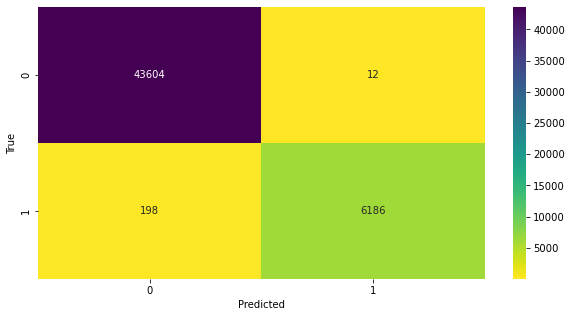

In [165]:
true_pos = conf_matx[0][0]
false_pos = conf_matx[1][0]
true_neg = conf_matx[1][1]
false_neg = conf_matx[0][1]

precision = true_pos/(true_pos + false_pos)

recall = true_pos/(true_pos + false_neg)

auroc = roc_auc_score(y_tsamp,pred)

print(f'Precision: {precision:.3f}')
print(f'Recall: {recall:.3f}')
print(f'AUROC: {auroc:.3f}')

plt.figure(figsize=(10,5))
ax = sns.heatmap(conf_matx, cmap='viridis_r', annot=True, fmt='d')
#ax = sns.heatmap(conf_matx, cmap='viridis_r', annot=True, fmt='d', yticklabels=['non-default','default'], xticklabels=['non-default','default'])
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
plt.show()


Predicting all majority class: 0.8723
XGBoost ROC AUC: 0.9844
Best F2 Score: 0.9745


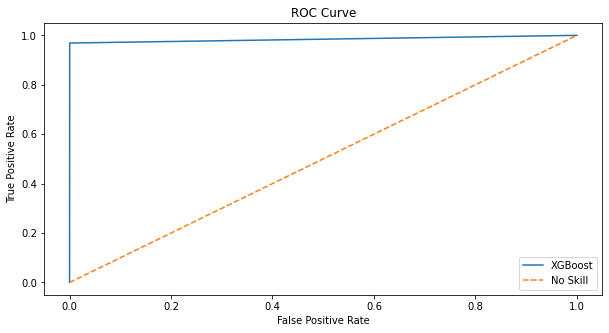

In [164]:
#Evaluating on F2 Score but just looking at area under ROC curve

print(f'Predicting all majority class: {Counter(y_tsamp)[0]/(Counter(y_tsamp)[0]+Counter(y_tsamp)[1]):.4f}')

print(f'XGBoost ROC AUC: {auroc:.4f}')

print(f'Best F2 Score: {grid.best_score_:.4f}')

fpr, tpr, _ = roc_curve(y_tsamp,pred)

plt.figure(figsize=(10,5))
plt.plot(fpr,tpr, label='XGBoost')
plt.plot([0,1],[0,1], linestyle='--', label = 'No Skill')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

## Tuned XGBoost

In [135]:
%%time

model_tune = XGBClassifier()

pipe_tune = Pipeline(steps=[
    ('preprocess',ct),
    ('model_tune', model_tune)
])

cv_tune = RepeatedStratifiedKFold(n_splits=10, n_repeats=2, random_state=42)

param_grid_tune = [
    {'model_tune__scale_pos_weight': [1,5,25,50,100,1000],
     'model_tune__n_estimators' : [50, 100, 250],
     'model_tune__max_depth' : [4,6,8,10],
     'model_tune__eta' : [0.0001, 0.001, 0.01, 0.1],
    'model_tune__subsample' : [0.4, 0.6, 0.8, 1.0],
    'model_tune__colsample bytree' : [0.4, 0.6, 0.8, 1.0]}
     ]

grid_tune = GridSearchCV(estimator=pipe_tune, param_grid=param_grid_tune, n_jobs=-1, cv=cv_tune, scoring=metric, verbose=1) 

grid_result_tune = grid_tune.fit(X_samp, y_samp)

print(f'Best score:{grid_result_tune.best_score_}')
print(f'Best params:{grid_result_tune.best_params_}')

# scores = cross_val_score(pipe_tune, X_samp, y_samp, scoring=metric, cv=cv_tune, n_jobs=-1)

Fitting 20 folds for each of 6 candidates, totalling 120 fits


/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3237: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:53:43] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best score:0.9819547413474512
Best params:{'model_tune__scale_pos_weight': 50}
CPU times: user 1min, sys: 1.71 s, total: 1min 2s
Wall time: 14min 58s


In [136]:
pred_tune = grid_tune.predict(X_tsamp)

conf_matx_tune = confusion_matrix(y_tsamp, pred_tune)

print(conf_matx_tune) 

classif_report_tune = classification_report(y_tsamp,pred_tune,digits=3)

print(classif_report_tune)

[[43560    56]
 [  135  6249]]
              precision    recall  f1-score   support

           0      0.997     0.999     0.998     43616
           1      0.991     0.979     0.985      6384

    accuracy                          0.996     50000
   macro avg      0.994     0.989     0.991     50000
weighted avg      0.996     0.996     0.996     50000



In [137]:
grid_result.best_estimator_.predict(X_tsamp)

print(confusion_matrix(y_tsamp,grid_result.best_estimator_.predict(X_tsamp)))

[[43604    12]
 [  198  6186]]


Precision: 0.995
Recall: 1.000
AUROC: 0.989


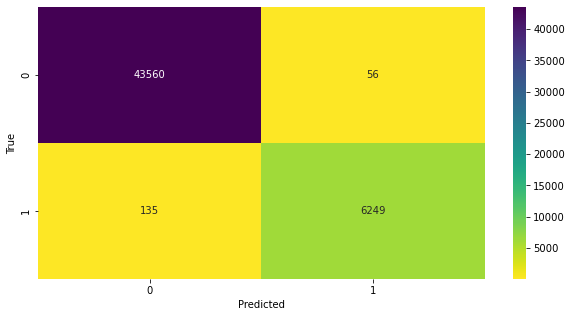

In [166]:
true_pos_tune = conf_matx[0][0]
false_pos_tune = conf_matx[1][0]
true_neg_tune = conf_matx[1][1]
false_neg_tune = conf_matx[0][1]

precision_tune = true_pos_tune/(true_pos_tune + false_pos_tune)

recall_tune = true_pos_tune/(true_pos_tune + false_neg_tune)

auroc_tune = roc_auc_score(y_tsamp,pred_tune)

print(f'Precision: {precision_tune:.3f}')
print(f'Recall: {recall_tune:.3f}')
print(f'AUROC: {auroc_tune:.3f}')

plt.figure(figsize=(10,5))
ax_tune = sns.heatmap(conf_matx_tune, cmap='viridis_r', annot=True, fmt='d')
#ax_tune = sns.heatmap(conf_matx, cmap='viridis_r', annot=True, fmt='d', yticklabels=['non-default','default'], xticklabels=['non-default','default'])
ax_tune.set_xlabel('Predicted')
ax_tune.set_ylabel('True')
plt.show()


Predicting all majority class: 0.8723
XGBoost ROC AUC: 0.9888


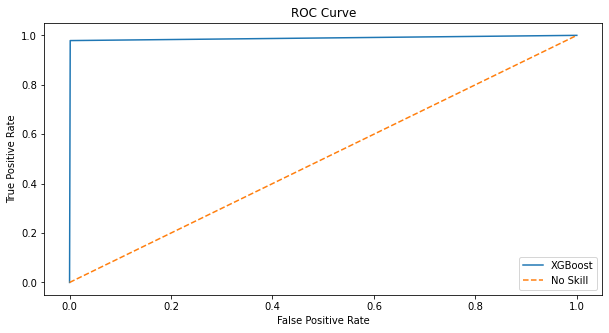

In [162]:
#Evaluating on F2 Score but just looking at area under ROC curve

print(f'Predicting all majority class: {Counter(y_tsamp)[0]/(Counter(y_tsamp)[0]+Counter(y_tsamp)[1]):.4f}')

print(f'XGBoost ROC AUC: {auroc_tune:.4f}')

fpr_tune, tpr_tune, _ = roc_curve(y_tsamp,pred_tune)

plt.figure(figsize=(10,5))
plt.plot(fpr_tune,tpr_tune, label='XGBoost')
plt.plot([0,1],[0,1], linestyle='--', label = 'No Skill')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

## Feature Importance (Base Model)

In [140]:
feature_import = grid_result.best_estimator_._final_estimator.feature_importances_

In [141]:
#Get feature names
feat_fit = pipe.fit(X_samp, y_samp)
onehot_cat_cols = feat_fit.named_steps['preprocess'].transformers_[0][1].named_steps['onehot'].get_feature_names(cat_ix)

onehot_cat_cols = list(onehot_cat_cols)

features = list(onehot_cat_cols)
features.extend(num_ix)

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3237: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:53:55] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [142]:
feat_count = 25

feature_importance = pd.Series(index=features, data=feature_import).nlargest(feat_count)
feature_importance

last_fico_range_high           0.423947
term                           0.105842
last_pymnt_amnt                0.083712
last_pymnt_d_rel               0.076627
loan_amnt                      0.054255
total_rec_prncp                0.031651
funded_amnt                    0.029450
hardship_flag_N                0.013681
out_prncp                      0.012306
issue_d_rel                    0.011210
installment                    0.011087
total_rec_late_fee             0.010969
last_credit_pull_d_rel         0.007409
application_type_Individual    0.006196
zip_code_331xx                 0.005693
num_actv_bc_tl                 0.003458
purpose_medical                0.003231
total_rec_int                  0.002883
percent_bc_gt_75               0.002766
int_rate                       0.002599
addr_state_FL                  0.002554
num_actv_rev_tl                0.002544
total_il_high_credit_limit     0.002393
acc_open_past_24mths           0.002388
num_op_rev_tl                  0.002372


In [143]:
#Check importance type

grid_result.best_estimator_['model']

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

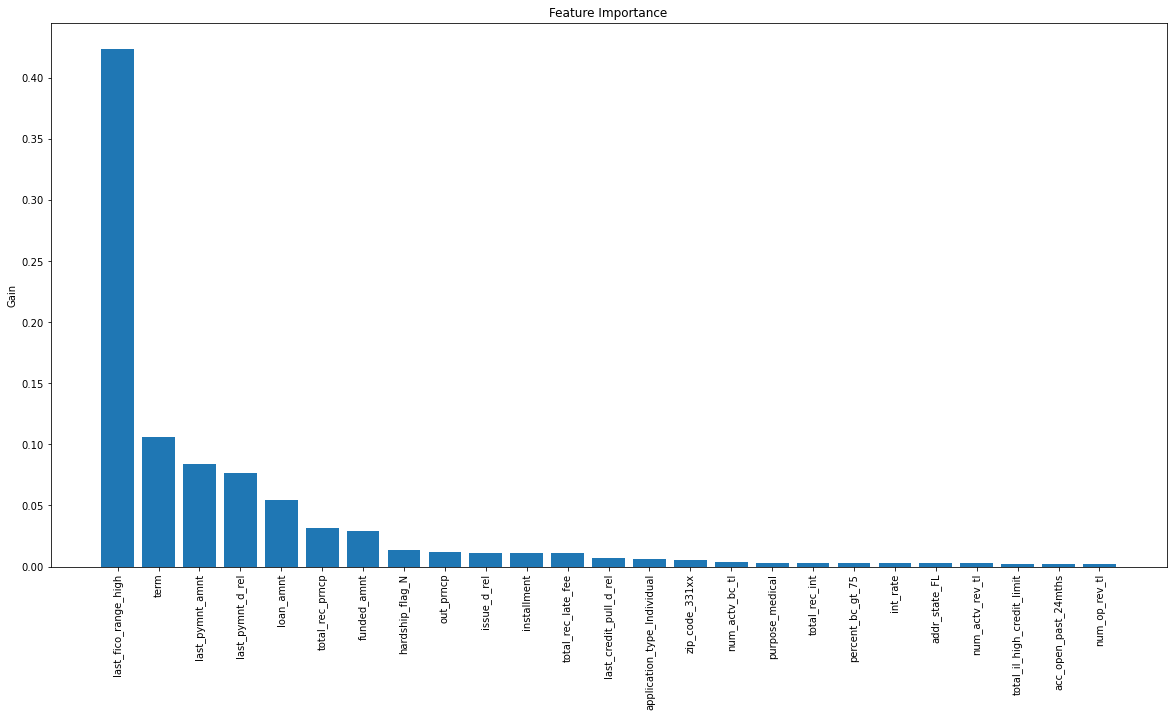

In [144]:
plt.figure(figsize=(20,10))
plt.bar(feature_importance.index,feature_importance.values)
plt.xticks(rotation=90)
plt.title('Feature Importance')
plt.ylabel('Gain')
plt.show()

In [145]:
eli5.explain_weights(grid_result.best_estimator_['model'], top=feat_count, feature_names = features)

Weight,Feature
0.4239,last_fico_range_high
0.1058,term
0.0837,last_pymnt_amnt
0.0766,last_pymnt_d_rel
0.0543,loan_amnt
0.0317,total_rec_prncp
0.0295,funded_amnt
0.0137,hardship_flag_N
0.0123,out_prncp
0.0112,issue_d_rel


In [146]:
pd.set_option('display.max_colwidth', None)
definitions = pd.read_excel('https://resources.lendingclub.com/LCDataDictionary.xlsx',usecols=['LoanStatNew','Description'])

In [147]:
for i in feature_importance.index:
    print(definitions[definitions['LoanStatNew'] == i]['Description'])
    print()

37    The upper boundary range the borrower’s last FICO pulled belongs to.
Name: Description, dtype: object

94    The number of payments on the loan. Values are in months and can be either 36 or 60.
Name: Description, dtype: object

39    Last total payment amount received
Name: Description, dtype: object

Series([], Name: Description, dtype: object)

41    The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value.
Name: Description, dtype: object

109    Principal received to date
Name: Description, dtype: object

23    The total amount committed to that loan at that point in time.
Name: Description, dtype: object

Series([], Name: Description, dtype: object)

80    Remaining outstanding principal for total amount funded
Name: Description, dtype: object

Series([], Name: Description, dtype: object)

33    The monthly payment owed by the borrower if the loan originates.
Na

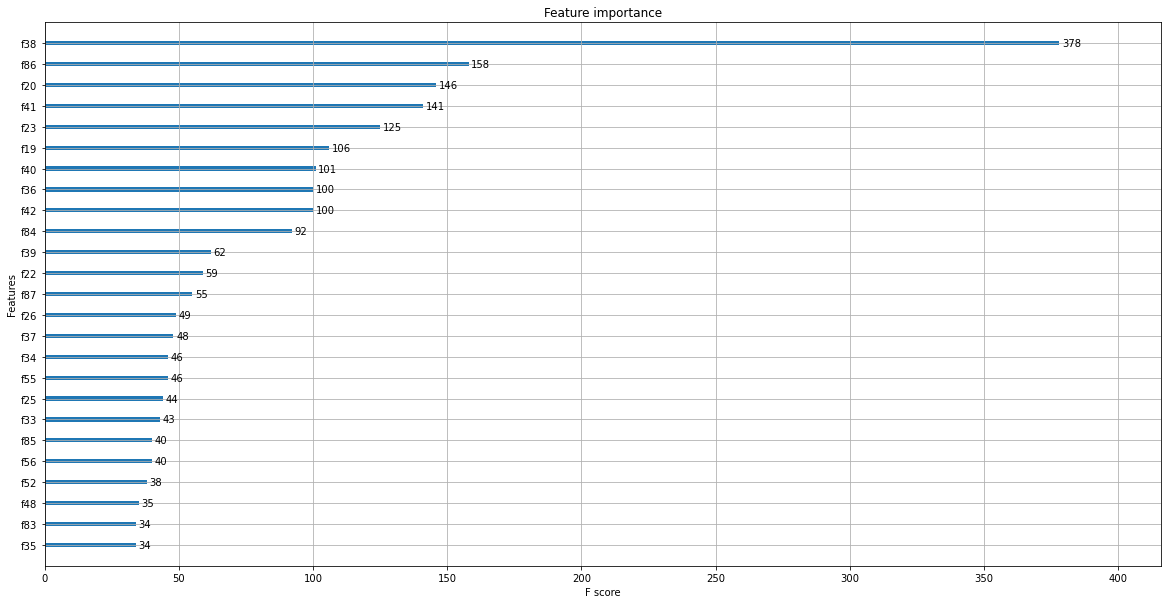

In [148]:
plt.rcParams["figure.figsize"] = (20, 10)
plot_importance(grid_result.best_estimator_['model'], max_num_features=feat_count)
plt.show()

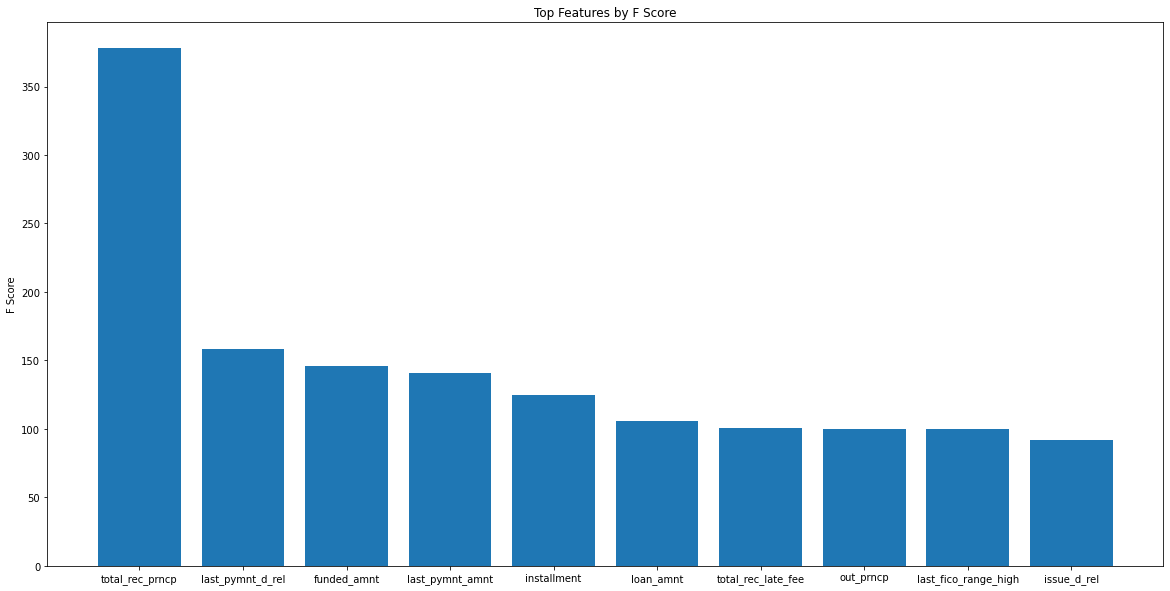

In [149]:
f_score_dict = {features[38] : 378,
                features[86] : 158,
                features[20] : 146,
                features[41] : 141,
                features[23] : 125,
                features[19] : 106,
                features[40] : 101,
                features[36] : 100,
                features[42] : 100,
                features[84] : 92
               }

#print(f_score_dict.keys())

plt.figure(figsize=(20,10))
plt.bar(f_score_dict.keys(),f_score_dict.values())
plt.title('Top Features by F Score')
plt.ylabel('F Score')
plt.show()

In [150]:
#Plot Correlation of the most important features

## Feature Importance (Tuned Model)

In [151]:
feature_import_tune = grid_result_tune.best_estimator_._final_estimator.feature_importances_

In [152]:
feature_importance_tune = pd.Series(index=features, data=feature_import_tune).nlargest(feat_count)
feature_importance_tune

last_fico_range_high                0.333420
last_pymnt_amnt                     0.116959
last_pymnt_d_rel                    0.065969
total_rec_late_fee                  0.058231
loan_amnt                           0.037597
pymnt_plan_n                        0.030564
total_rec_prncp                     0.024775
funded_amnt                         0.021113
zip_code_891xx                      0.017313
installment                         0.012964
purpose_car                         0.010934
purpose_medical                     0.010930
tot_hi_cred_lim                     0.010171
term                                0.009427
bc_open_to_buy                      0.008924
last_fico_range_low                 0.008731
verification_status_Not_Verified    0.008325
total_bal_ex_mort                   0.007769
addr_state_PA                       0.006536
mort_acc                            0.006220
num_tl_op_past_12m                  0.006157
home_ownership_OWN                  0.005881
total_pymn

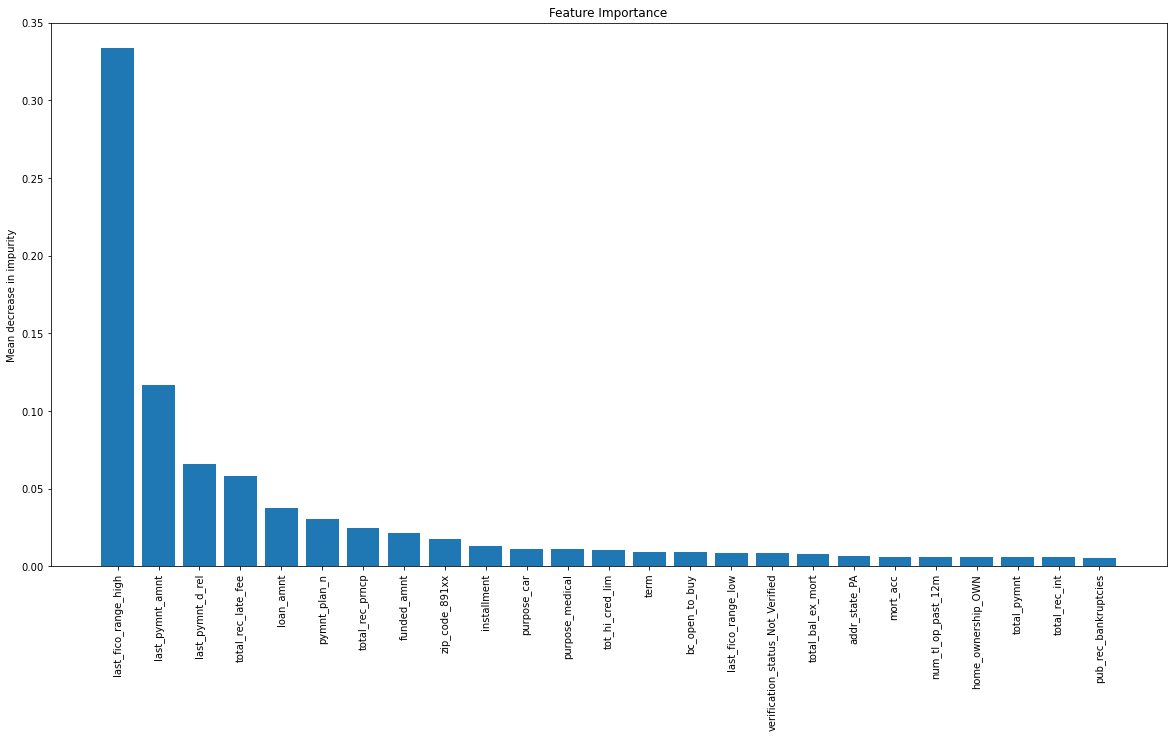

In [153]:
plt.figure(figsize=(20,10))
plt.bar(feature_importance_tune.index,feature_importance_tune.values)
plt.xticks(rotation=90)
plt.title('Feature Importance')
plt.ylabel('Mean decrease in impurity')
plt.show()

In [154]:
eli5.explain_weights(grid_result_tune.best_estimator_['model_tune'], top=feat_count, feature_names = features)

Weight,Feature
0.3334,last_fico_range_high
0.1170,last_pymnt_amnt
0.0660,last_pymnt_d_rel
0.0582,total_rec_late_fee
0.0376,loan_amnt
0.0306,pymnt_plan_n
0.0248,total_rec_prncp
0.0211,funded_amnt
0.0173,zip_code_891xx
0.0130,installment


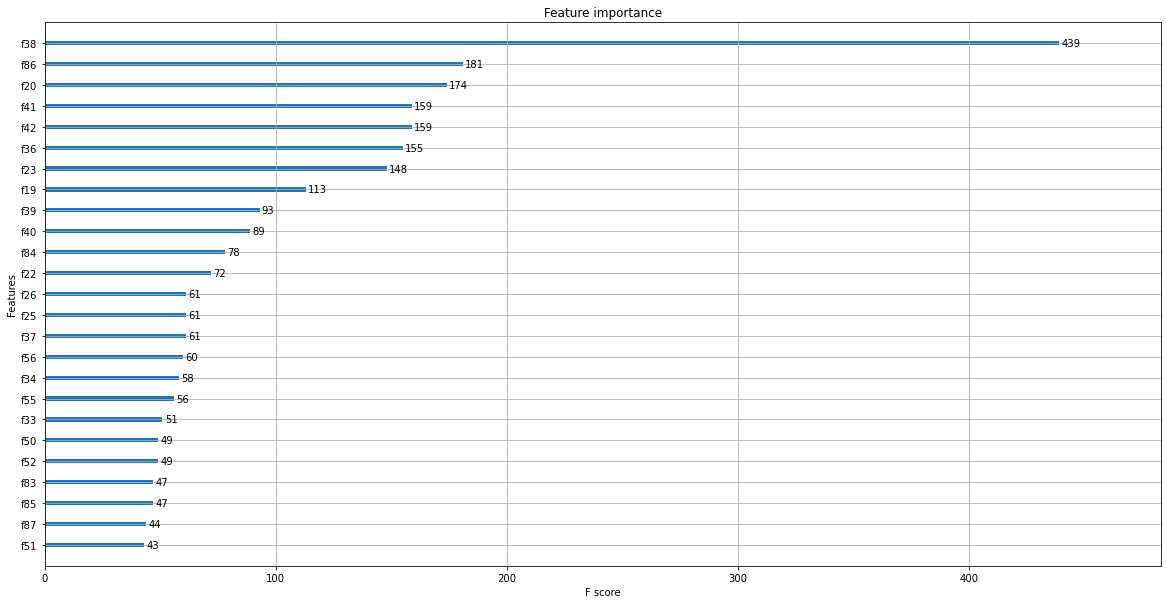

In [155]:
plt.rcParams["figure.figsize"] = (20, 10)
plot_importance(grid_result_tune.best_estimator_['model_tune'], max_num_features=feat_count)
plt.show()

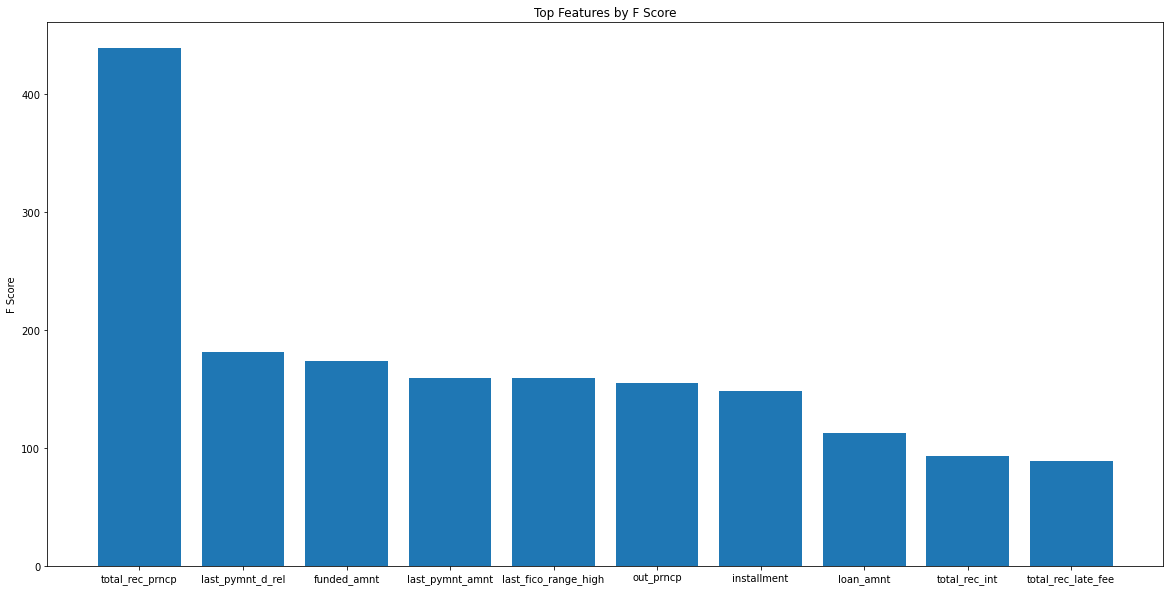

In [163]:
f_score_dict_tune = {features[38] : 439,
                features[86] : 181,
                features[20] : 174,
                features[41] : 159,
                features[42] : 159,
                features[36] : 155,
                features[23] : 148,
                features[19] : 113,
                features[39] : 93,
                features[40] : 89
               }

#print(f_score_dict.keys())

plt.figure(figsize=(20,10))
plt.bar(f_score_dict_tune.keys(),f_score_dict_tune.values())
plt.title('Top Features by F Score')
plt.ylabel('F Score')
plt.show()

In [157]:
#Plot Correlation of the most important features

# END